### Code refacoring

The intent here is to go through my high-level UI and clean up structure issues and look for bugs.

The first thing we will do is make the time-distance binning better. Currently what I do is handle time and distance seperately, 
adapting the width of the bins so that we get the same (or similar) number of trips in each bin.

Options include (from worst to best):
    - Adding small random noise onto time and distance values so that they are unique
    - Fitting a polynomial to the values and using interpolation.
    - Binning based on the time-distance surface, instead of each independantly.
        - I'll at least make a plot, but this might not be convex and I don't really know if it buys us much.


In [1]:
from Fair_Fare.feature_utils import load_hdf
#from Fair_Fare.aggregations import bin_on_time_distance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
matplotlib.rcParams['figure.dpi'] = 144

from Fair_Fare.aggregations import bin_on_time_distance


%load_ext autoreload
%autoreload 2



In [2]:
models = {"path":"models/", "taxi":"taxi_xgb_full_reduced_params", "rideshare":"tnp_xgb_full_reduced_params" }
data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

taxi_data = load_hdf(data['path']+data['taxi'])

rideshare_data = load_hdf(data['path']+data['rideshare'])

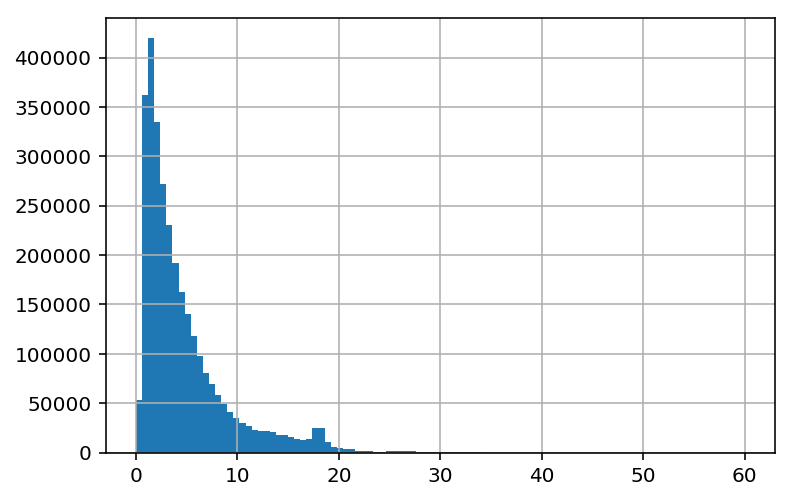

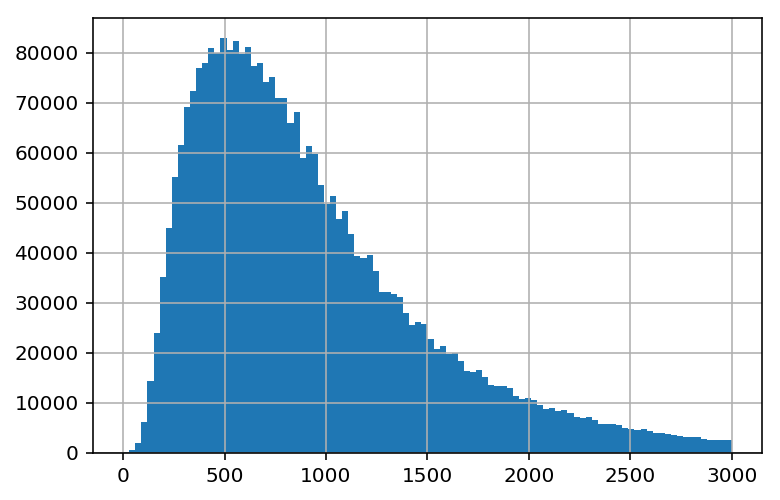

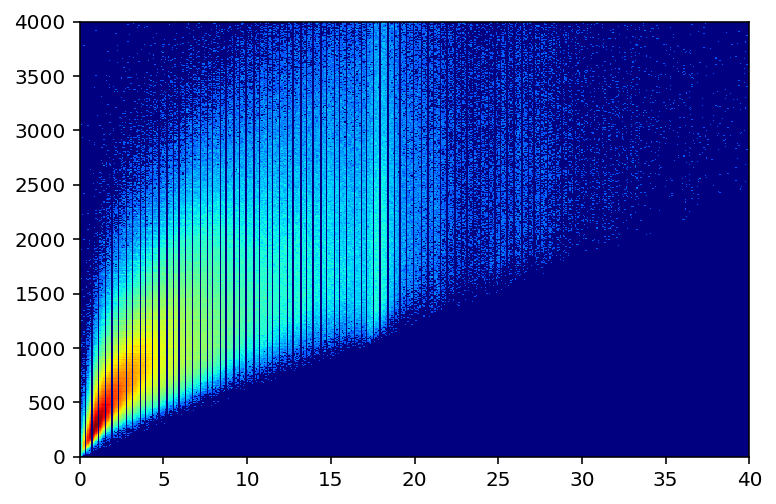

In [24]:

rideshare_data.Trip_Miles.hist(bins = 100, range = (0,60))
plt.show()
rideshare_data.Trip_Seconds.hist(bins = 100, range = (0,3000))
plt.show()

x = rideshare_data.Trip_Miles.values
y = rideshare_data.Trip_Seconds.values

plt.hist2d(x, y, bins=(500, 500), cmap=plt.cm.jet, range = ((0,40),(0,4000)),norm=mcolors.PowerNorm(0.2))
plt.show()

#plt.plot(np.sort(rideshare_data.Trip_Miles.values))
#plt.ylim([0,10])

In [76]:
binned  =bin_on_time_distance(rideshare_data, (50,0),seconds_cutoff = 3000,miles_cutoff = 20)
print(binned.df.groupby('miles_b').Trip_Miles.count()[:10])
print(binned.df.groupby('seconds_b').Trip_Miles.count()[:10])
print(binned.df.groupby('td_bin').Trip_Miles.count()[0:10])

miles_b
0    61288
1    61337
2    60413
3    61080
4    61454
5    62032
6    60643
7    59594
8    61406
9    60390
Name: Trip_Miles, dtype: int64
seconds_b
0    61918
1    61541
2    60148
3    63057
4    58617
5    62137
6    61025
7    61403
8    59640
9    60252
Name: Trip_Miles, dtype: int64
td_bin
(0.0, 0.0)    32571
(0.0, 1.0)    15265
(0.0, 2.0)     7287
(0.0, 3.0)     3584
(0.0, 4.0)     1679
(0.0, 5.0)      799
(0.0, 6.0)      364
(0.0, 7.0)      177
(0.0, 8.0)       73
(0.0, 9.0)       43
Name: Trip_Miles, dtype: int64


So even though the algoritim takes smller bins where we have more data in 1-d, certain bins (eg.. along the diagonal in the density plot above) have much more data. One could adapt the grid in 2d to have constant density in each bin. I don't really think that's worth it. In that case, points near the edge of the bin could go into either of two groups so the bins become less representative. I think the absolute 'correct' way to do this would be:
- Represent each trip as a node on a graph with time and distance attributes.
- When a node is requested, compute the nearest N other nodes to use for aggregates.

However, this is computationally expensive at runtime over just pre-binning and selecting the bin.

miles_b
0    61133
1    61559
2    60640
3    61096
4    62261
5    61298
6    59883
7    60264
8    60871
9    62329
Name: Trip_Miles, dtype: int64
seconds_b
0    61918
1    61541
2    60148
3    63057
4    58617
5    62137
6    61025
7    61403
8    59640
9    60252
Name: Trip_Miles, dtype: int64


In [73]:
print(binned.df.groupby('td_bin').Trip_Miles.count()[0:10])

td_bin
(0.0, 0.0)    32474
(0.0, 1.0)    15331
(0.0, 2.0)     7370
(0.0, 3.0)     3524
(0.0, 4.0)     1701
(0.0, 5.0)      773
(0.0, 6.0)      376
(0.0, 7.0)      180
(0.0, 8.0)       67
(0.0, 9.0)       46
Name: Trip_Miles, dtype: int64
